# Homework 8 - Renormalization Group #

# Consegna #

Consider the quantum Ising Hamiltonian in transverse field on a one-dimensional lattice with the nearest neighbour interaction:
$$
\hat{H} = \lambda {\sum_i}^N {\sigma_i}^z + {\sum_i}^{N-1} {\sigma_i}^x {\sigma_{i+1}}^x 
$$

where $\sigma^x$ and $\sigma^z$ and $\lambda$ is the transverse field. 

(a) Compute the ground state energy as a function of the transverse field 𝜆 by means of the real-space
RG algorithm.

(b) $\textit{Optional}$: Compute the ground state energy as a function of 𝜆 by means of the INFINITE DMRG
algorithm. Compare the results between them and with the mean field solution.


**Teoria a pag. pdf 49 del libro di Montangero**

Real-space renormalization group method is an approximation method based on a very powerful physical intuition: the hypothesis that the ground state of a system is composed of low-energy states of the system’s (non-interacting) bipartitions. Based on this assumption, it is indeed possible to introduce an algorithm that allows describing the ground state properties of many-body quantum systems with large sizes $( N )$, up to the thermodynamical limit corresponding to the fixed point of the renormalization flow.

The algorithm proceeds as follows:

1. **Initialize**:  
   Consider a system composed of $( N )$ sites that can be studied in an exact numerical way. Build the Hamiltonian $( H_N : \mathbb{C}^{dN} \to \mathbb{C}^{dN} )$.

2. **Diagonalize the Hamiltonian**:  
   Diagonalize $( H_N )$, finding its eigenvalues and eigenvectors:
   $$
   H_N = \sum_{i=1}^{d^N} E_i \lvert E_i \rangle \langle E_i \rvert,
   $$
   where the eigenvalues $( E_i )$ are in increasing order.  
   Consider the projector onto the lowest $( m )$ eigenstates:
   $$
   P = \sum_{i=1}^m \lvert E_i \rangle \langle E_i \rvert,
   $$
   which projects the Hilbert space onto the subspace spanned by the first $( m )$ low-energy eigenstates.  
   Compute the projected Hamiltonian:
   $$
   \tilde{H}_N = P^\dagger H_N P,
   $$
   as well as any other needed operator representation in the projected space:
   $$
   \tilde{O} = P^\dagger O P.
   $$

3. **Construct the larger system Hamiltonian**:  
   Construct the Hamiltonian of a system of size $( 2N )$ using the projected Hamiltonian $( \tilde{H}_N )$ for each bipartition and the interaction among them:
   $$
   H_{2N} = \tilde{H}_N \otimes 1 + 1 \otimes \tilde{H}_N + \tilde{H}_{\text{int}}.
   $$
   The interaction Hamiltonian can be obtained as:
   $$
   \tilde{H}_{\text{int}} = \tilde{A}_N \otimes \tilde{B}_N,
   $$
   where $( \tilde{A} )$ ($( \tilde{B} )$) are the projected operators acting on each system bipartition:
   $$
   \tilde{A} = P^\dagger A P, \quad \tilde{B} = P^\dagger B P.
   $$

4. **Repeat until convergence**:  
   Repeat steps 2–3 until the desired system size is reached or convergence to the renormalization group fixed point is achieved.  
   At each step of the algorithm, the dimension of the described system is doubled ($( N \to 2N )$) while the dimension of the Hamiltonian representation is kept constant at $( m )$.



**metti a posto le formule in latex**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aux
import ising as ig
import scipy.sparse as sp

In [55]:
def proj(ham, m):
    _, eigenvectors = sp.linalg.eigsh(ham, k= m, which='SA')     # they're alrady sorted in ascending order
    proj = sp.csr_matrix(eigenvectors)
    return proj

def initialize_part(N):
    
    sigma_x, _, _ = aux.pauli_matrices()
    
    A_0 = sp.kron(sp.identity(2**(N-1),format='csr'),sigma_x)
    B_0 = sp.kron(sigma_x,sp.identity(2**(N-1),format='csr'))
    return A_0, B_0

def ham_2N(ham,A,B):
    left = sp.kron(ham,sp.identity(ham.shape[0],format='csr'))
    right = sp.kron(sp.identity(ham.shape[0],format='csr'),ham)
    AB = sp.kron(A,B)
    ham2N = left + right + AB
    if ham2N.shape != (int(2**(2*np.log2(ham.shape[0]))),int(2**(2*np.log2(ham.shape[1])))):
        aux.checkpoint(True,verb=3,
                       msg='Shapes of new Hamiltonian should be = 2*(shape of the original Hamiltonian).Instead got', var=ham2N.shape)
    return ham2N

def update_op(N, ham2N, A, B, m):
    P = proj(ham2N,m)
    P_dag = P.conj().T
    ham_new = P_dag @ ham2N @ P
    A_new = P_dag @ sp.kron(sp.identity(2**N,format='csr'),A) @ P
    B_new = P_dag @ sp.kron(B,sp.identity(2**N,format='csr')) @ P
    return ham_new, A_new, B_new

def energy_conv(N, ham, ham_new, m, tau, verb: int=1):
    N_new = 2 * N
    print('Ham:', ham.shape)
    eigvals, _ = sp.linalg.eigsh(ham, m, which='SA')
    eigvals_new, _ = sp.linalg.eigsh(ham_new, m, which='SA')
    E = eigvals[0]
    E_new = eigvals_new[0]
    condition = np.abs(E_new/N_new - E/N) < tau
    if verb == 1:
        if condition:
            print('Convergence reached!')
    if verb == 2:
        if condition:
            print('Convergence reached!')
        return condition, E_new/N_new, E/N
    if verb > 2:
        if condition:
            print('Convergence reached!')
            print(f'Energy density at previous step: {E/N}')
            print(f'Energy density at current step: {E_new/N_new}')
        else: 
            print(f'Energy density at previous step: {E/N}')
            print(f'Energy density at current step: {E_new/N_new}')
        return condition, E_new/N_new, E/N
    

def real_space_rg(N, m, tau, lam: float=1.0, max_iterations: int =100):
    
    prev_energy_density = np.inf
    ham = ig.sparse_ising(N,lam)
    A, B = initialize_part(N)
    curr_N = N
    
    # Initialize a list for the energies
    energy_densities = np.zeros(max_iterations)
    deltas = np.zeros(max_iterations)

    for it in range(1,max_iterations):
        curr_N *= 2
        if it % 10 == 0:
            print(f"Starting iteration {it} ...")
        
        # Compute the new Hamiltonian
        ham2N = ham_2N(ham, A, B)
        
        # Compute the new energy 
        E_curr, _ = sp.linalg.eigsh(ham2N, k=m,which='SA')
        curr_energy_density = E_curr[0]/curr_N
        delta = np.abs(curr_energy_density - prev_energy_density)
        
        # Append the energy to the energy list
        energy_densities[it] = curr_energy_density
        deltas[it] = delta
        
        if delta < tau:
            print(f'Convergence reached at N = {curr_N} after {it} iterations.')
            return energy_densities, deltas
        
        prev_energy_density = curr_energy_density 
            
        # update
        ham, A, B = update_op(N, ham2N,A,B,m)
    
    print('Maximum iterations reached!')
    return energy_densities, deltas
        


Starting iteration 10 ...
Convergence reached at N = 16384 after 13 iterations.


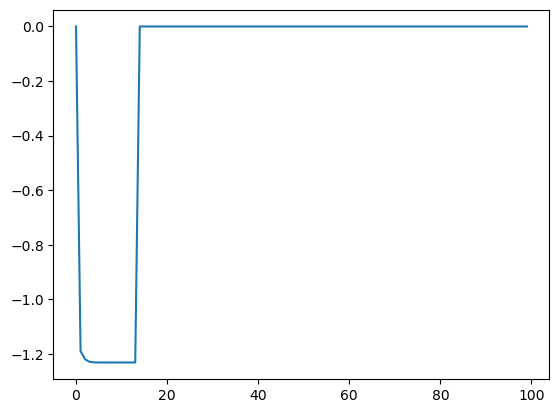

In [57]:
# for the Hamiltonian I use the code already developed for the previous assignment

N = 2
lam = 1
m = 2*N
tau = 1e-14
max_iter = 100

energy_densities, deltas = real_space_rg(N=N, m=m, tau=tau,lam=lam, max_iterations=max_iter)

plt.plot(np.arange(100), energy_densities)


